In [ ]:
pip install transformers==2.6.0

     |████████████████████████████████| 542kB 10.4MB/s 
     |████████████████████████████████| 1.1MB 14.2MB/s 
     |████████████████████████████████| 133kB 58.8MB/s 
     |████████████████████████████████| 890kB 52.1MB/s 
     |████████████████████████████████| 3.7MB 55.9MB/s 
     |████████████████████████████████| 6.9MB 52.1MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=6b6d1f4c587beeaf6eab16e5a0b78cd1dabf31f98980c854f1b38c532dee02dd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.25 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print(torch.cuda.get_device_name(0))


Tesla P100-PCIE-16GB


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [ ]:
# total_data = pd.read_csv("tsd_train.csv", encoding="latin1").fillna(method="ffill")

# df = total_data
# df['split'] = np.random.randn(df.shape[0], 1)

# msk = np.random.rand(len(df)) <= 0.9

# data = df[msk]
# # data=
# testa = df[~msk]
# data.tail(5)

In [ ]:
data = pd.read_csv("trainfinal.csv", encoding="latin1").fillna(method="ffill")
# df = total_data
print(len(data))
data.tail(5)

6351


spans                                               text
6346  [684, 685, 686, 687, 688, 689, 703, 704, 705, ...  As for Clinton, it's well known why Putin want...
6347            [46, 47, 48, 49, 98, 99, 100, 101, 102]  Because the author with this steaming pile of ...
6348               [11, 12, 13, 14, 15, 16, 17, 18, 19]                              Manifestly ludicrous.
6349                           [21, 22, 23, 24, 25, 26]  No need ban.  Anyone stupid enough to go to N....
6350  [276, 277, 278, 279, 280, 281, 282, 283, 284, ...  âDoes this guy have anything better to do wi...

In [ ]:
data.head(5)
data=data[:(int)(0.8*len(data))]
print(len(data))
data.head(5)

5080


spans                                               text
0                                      [7, 8, 9, 10]  Only a fool would not be against this presiden...
1  [9, 10, 11, 12, 13, 14, 15, 16, 17, 55, 56, 57...  cops are dumbasses anyways and any male from u...
2                                 [2, 3, 4, 5, 6, 7]  A stupid post by a troll.  Thanks for outing y...
3                            [5, 6, 7, 8, 9, 10, 11]  Most idiotic, heartless comment I think I've e...
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  Some of you might have, but if you supported H...

In [ ]:
def str_to_int(input_span):
    input_span=input_span[1:-1]
    if not input_span:
        return []
    splited_span=(input_span.split(", "))

    for i in range(len(splited_span)):
        splited_span[i]=int(splited_span[i])
    return splited_span


def split_text(input_text):
    if not input_text:
        return input_text
    splited_text=(input_text.split())
    return splited_text

def labels_conv(input_spans,input_text,splited_text):
    if not input_spans:
        return ['0']*len(splited_text)
    every_element=np.zeros(len(input_text))
    for i in input_spans:
        every_element[i]=1;
    output_labels=['0']*len(splited_text)
    j=0
    for i in range(len(splited_text)):
        if(every_element[j]==1):
            output_labels[i]='1'
        j=j+len(splited_text[i])+1
    return output_labels

In [ ]:
data["in_spans"] = data.apply(lambda row:str_to_int(row.spans), axis=1)

data["in_text"] = data.apply(lambda row:split_text(row.text), axis=1)

data["labels"] = data.apply(lambda row:labels_conv(row.in_spans,row.text,row.in_text), axis=1)

In [ ]:
data.head(10)

spans  ...                                             labels
0                                      [7, 8, 9, 10]  ...  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1  [9, 10, 11, 12, 13, 14, 15, 16, 17, 55, 56, 57...  ...  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2                                 [2, 3, 4, 5, 6, 7]  ...                     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
3                            [5, 6, 7, 8, 9, 10, 11]  ...               [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
5                           [20, 21, 22, 23, 24, 25]  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6       [15, 16, 17, 18, 19, 26, 27, 28, 29, 30, 31]  ...                              [0, 0, 0, 0, 1, 0, 1]
7                   [37, 38, 39, 40, 41, 42, 43, 44]  ...               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
8  [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...  ...  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
9  [29, 30, 31, 32, 33, 34, 35, 36, 37, 134, 135,...  ...  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

[10 rows x 5 columns]

In [ ]:
arraysentences=data["in_text"]
arraylabels = data["labels"]

sentences=arraysentences.to_list()
labels = arraylabels.to_list()

In [ ]:
# data["labels"][0]

In [ ]:
# tag_values = list(set(data["labels"][0]))
tag_values = ['1','0']

In [ ]:
# tag_values = list(set(data["labels"][0]))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'0': 1, '1': 0, 'PAD': 2}

In [ ]:
MAX_LEN = 100
bs = 32

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=False)

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        # print(word)
        # print(label)
        tokenized_word = tokenizer.tokenize(word)
        # print('tokenized_word -> ')
        # print(tokenized_word)
        n_subwords = len(tokenized_word)
        # print('n_subwords-> ')
        # print(n_subwords)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [ ]:
print(sentences[0])
print(labels[0])

['Only', 'a', 'fool', 'would', 'not', 'be', 'against', 'this', 'president.', 'He', 'is', 'massively', 'and', 'obviously', 'unfit', 'for', 'office.']
['0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [ ]:
# sss=sentences[0]
# lll=labels[0]
# tokenize_and_preserve_labels(sss,lll)

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [ ]:
input_ids

array([[ 2809,   170,  8906, ...,     0,     0,     0],
       [11396,  1132, 14908, ...,  1665,  1233, 24181],
       [  138,  4736,  2112, ...,     0,     0,     0],
       ...,
       [ 2119,  1163,   117, ...,     0,     0,     0],
       [15386,  1158, 13037, ...,     0,     0,     0],
       [ 1327,   170,  1703, ...,  1105,  1383,  1366]])

In [ ]:
# tr_inputs

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [ ]:
tags

array([[1, 1, 0, ..., 2, 2, 2],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 0, ..., 2, 2, 2],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [ ]:



# tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
#                                                             random_state=2018, test_size=0.1)
# tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
#                                              random_state=2018, test_size=0.1)

tr_inputs = input_ids
tr_tags =  tags
tr_masks = attention_masks



In [ ]:
data = pd.read_csv("trainfinal.csv", encoding="latin1").fillna(method="ffill")
data=data[(int)(0.8*len(data)):]
data["in_spans"] = data.apply(lambda row:str_to_int(row.spans), axis=1)

data["in_text"] = data.apply(lambda row:split_text(row.text), axis=1)

data["labels"] = data.apply(lambda row:labels_conv(row.in_spans,row.text,row.in_text), axis=1)




In [ ]:
arraysentences=data["in_text"]
arraylabels = data["labels"]

sentences=arraysentences.to_list()
labels = arraylabels.to_list()
####################################

tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]
###########################################

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
#################################################

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
 ##########################################################

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
#####################################################################

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
##########################################################################

val_inputs = input_ids
val_tags =  tags
val_masks = attention_masks

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'2.6.0'

In [ ]:
bert_type="bert-large-cased"

In [ ]:
# Bert Model with a token classification head on top (a linear layer on top of the hidden-states output) e.g. for Named-Entity-Recognition (NER) tasks.

model = BertForTokenClassification.from_pretrained(
    bert_type,
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.cuda();


In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=6da57a64e56348b8bb3080bcc6dc3301282f77908b3e594fd347dd1bd189958e
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()

    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0


    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    t0 = time.time()
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Average train loss: 0.29490125825944935
  Training epcoh took: 0:02:37


Epoch:  33%|███▎      | 1/3 [02:49<05:39, 169.83s/it]

Validation loss: 0.27839313056319953
Validation Accuracy: 0.9066863660114233
  Validation took: 0:00:12

Average train loss: 0.24472743999095833
  Training epcoh took: 0:02:37


Epoch:  67%|██████▋   | 2/3 [05:39<02:49, 169.85s/it]

Validation loss: 0.2671942260116339
Validation Accuracy: 0.9124520278913894
  Validation took: 0:00:12

Average train loss: 0.2011071707842485
  Training epcoh took: 0:02:38


Epoch: 100%|██████████| 3/3 [08:29<00:00, 169.92s/it]

Validation loss: 0.27494076266884804
Validation Accuracy: 0.9102538692996522
  Validation took: 0:00:12



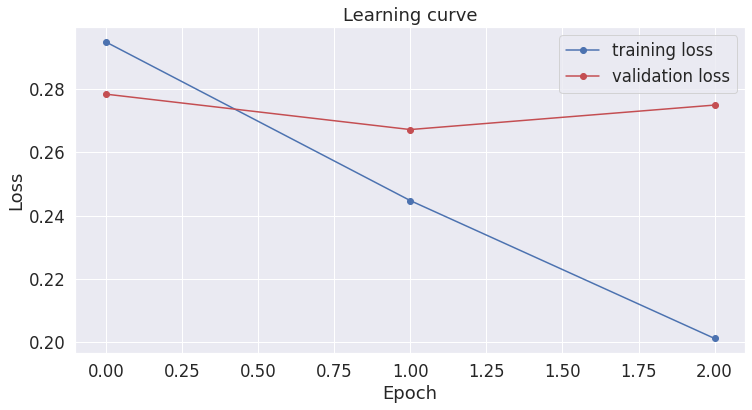

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
# from google.colab import files
# import os
# bert_type="bert-large-cased"
# epochs=4
# output_dir = './newmodel_save_'+str(bert_type)+'_'+str(epochs)+'.pth'


In [ ]:
from google.colab import files
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 # bert_type="bert-large-cased"
# epochs=4
output_dir = 'train_eval_'+str(bert_type)+'_'+str(epochs)+'_'+str(bs)+'_'+str(MAX_LEN)+'.pth'

# model_save_name = 'classifier.pt'
path = F"drive/My Drive/{output_dir}"
torch.save(model.state_dict(), path)

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
# model = TheModelClass(*args, **kwargs)


# torch.save(model.state_dict(), output_dir)


In [ ]:
# files.download(str(output_dir))
Model=model

In [ ]:
output_dir = "train_eval_bert-large-cased_4_32_100f1_0.5642318060183463.pth"
path = F"drive/My Drive/{output_dir}"

model.load_state_dict(torch.load(path))
model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [ ]:
#############################################################################

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        # print(word)
        # print(label)
        tokenized_word = tokenizer.tokenize(word)
        # print('tokenized_word -> ')
        # print(tokenized_word)
        n_subwords = len(tokenized_word)
        # print('n_subwords-> ')
        # print(n_subwords)
        for i in range(n_subwords):
            if tokenized_word[i].startswith("##"):
                continue
            if (tokenized_word[i][0] >= 'a' and tokenized_word[i][0] <= 'z') or (tokenized_word[i][0] >= 'A' and tokenized_word[i][0] <= 'Z'):
                tokenized_sentence.append(tokenized_word[i])
                labels.append(label)
            # else:


        # # Add the tokenized word to the final tokenized word list
        # tokenized_sentence.extend(tokenized_word)

        # # Add the same label to the new list of labels `n_subwords` times
        # labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
def output_on_test(test_sentence):
    # test_sentence = "Because he's an i..diot w*ho i''s moron and has a big bigot qualityufuyfuyuvyuv."

    test = test_sentence.split()
    # print(test)
    idsss,is_subword = tokenize_and_forsubword(test)

    idsss = tokenizer.tokenize(test_sentence)
    numid = tokenizer.convert_tokens_to_ids(idsss)
    numid.insert(0,101)
    numid.append(102)

    input_ids = torch.tensor([numid]).cuda()
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    input_ids=input_ids[0][1:-1]
    label_indices = label_indices[0][1:-1]

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy())
    # print(tokens)
    new_tokens, new_labels = [], []

    j=-1
    for i in range(len(is_subword)):

        # print(i,is_subword[i],j)
        if is_subword[i]==j:
            if tokens[i].startswith("##"):
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i][2:]
            else:
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i]
            # if label_indices[i]==0:
            #     new_labels[is_subword[i]]= tag_values[0]
        else :
            new_tokens.append(tokens[i])
            new_labels.append(tag_values[label_indices[i]])
            j=j+1
    span = []
    start=0
    for token, label in zip(new_tokens, new_labels):
        if label=='1':
            for i in range(len(token)):
                # if(token[i]=='.')continue;
                if (token[i]>='a' and token[i]<='z') or (token[i]>='A' and token[i]<='Z'):
                    span.append(start+i)
            # span.extend(np.arange(start,start+len(token),1))
        start=start+len(token)+1
    # print(span)
    return span

In [ ]:
def output_on_test_prediction(test_sentence):
    # test_sentence = "Because he's an i..diot w*ho i''s moron and has a big bigot qualityufuyfuyuvyuv."

    test = test_sentence.split()
    # print(test)
    idsss,is_subword = tokenize_and_forsubword(test)

    idsss = tokenizer.tokenize(test_sentence)
    numid = tokenizer.convert_tokens_to_ids(idsss)
    numid.insert(0,101)
    numid.append(102)

    input_ids = torch.tensor([numid]).cuda()
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    input_ids=input_ids[0][1:-1]
    label_indices = label_indices[0][1:-1]

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy())
    # print(tokens)
    new_tokens, new_labels = [], []

    j=-1
    for i in range(len(is_subword)):

        # print(i,is_subword[i],j)
        if is_subword[i]==j:
            if tokens[i].startswith("##"):
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i][2:]
            else:
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i]
            # if label_indices[i]==0:
            #     new_labels[is_subword[i]]= tag_values[0]
        else :
            new_tokens.append(tokens[i])
            new_labels.append(tag_values[label_indices[i]])
            j=j+1
    # span = []
    # start=0
    # for token, label in zip(new_tokens, new_labels):
    #     if label=='1':
    #             nontoxicwords.append(token)
    #         for i in range(len(token)):
    #             if (token[i]>='a' and token[i]<='z') or (token[i]>='A' and token[i]<='Z'):
    #                     span.append(start+i)
    #         # span.extend(np.arange(start,start+len(token),1))
    #     start=start+len(token)+1
    return new_labels

In [ ]:
def output_on_test_position(test_sentence):
    # test_sentence = "Because he's an i..diot w*ho i''s moron and has a big bigot qualityufuyfuyuvyuv."

    test = test_sentence.split()
    # print(test)
    idsss,is_subword = tokenize_and_forsubword(test)

    idsss = tokenizer.tokenize(test_sentence)
    numid = tokenizer.convert_tokens_to_ids(idsss)
    numid.insert(0,101)
    numid.append(102)

    input_ids = torch.tensor([numid]).cuda()
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    input_ids=input_ids[0][1:-1]
    label_indices = label_indices[0][1:-1]

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy())
    # print(tokens)
    new_tokens, new_labels = [], []
    nontoxicwords=[]
    j=-1
    for i in range(len(is_subword)):

        # print(i,is_subword[i],j)
        if is_subword[i]==j:
            if tokens[i].startswith("##"):
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i][2:]
            else:
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i]
            # if label_indices[i]==0:
            #     new_labels[is_subword[i]]= tag_values[0]
        else :
            new_tokens.append(tokens[i])
            new_labels.append(tag_values[label_indices[i]])
            j=j+1
    span = []
    start=0
    for token, label in zip(new_tokens, new_labels):
        if label=='1':
            nontoxicwords.append(token)
            # for i in range(len(token)):
            #     if (token[i]>='a' and token[i]<='z') or (token[i]>='A' and token[i]<='Z'):
            #             span.append(start+i)
            # span.extend(np.arange(start,start+len(token),1))
        start=start+len(token)+1
    return nontoxicwords

In [ ]:
#############################################################################
testa=pd.read_csv("devfinal.csv", encoding="latin1").fillna(method="ffill")
testa["in_text"] = testa.apply(lambda row:testa_conv(row.text), axis=1)
testa["preds"]=testa.apply(lambda row:output_on_test(row.text), axis=1)
testa["predlabels"]=testa.apply(lambda row:output_on_test_prediction(row.text), axis=1)
testa["toxic words"]=testa.apply(lambda row:output_on_test_position(row.text), axis=1)
testa["f1_scores"] = testa.apply(lambda row: f1(row.preds, strtointpart2(row.spans)), axis=1)
#############################################################################

In [ ]:
a=[]
for i in testa.f1_scores:
    a.append(i)
print(a)

if not a:
    print("test bana lo bhaiyaa")
else:
    print(sum(a)/len(a))

[0.7368421052631579, 0.25, 0.0, 0.34285714285714286, 0.631578947368421, 0.5555555555555556, 0.8571428571428571, 1.0, 0.8, 0.0, 0.0, 0.0, 0.391304347826087, 0.8421052631578947, 1.0, 0.0, 0.75, 0.6666666666666666, 0.631578947368421, 1.0, 0.0, 0.19642857142857142, 0.6666666666666666, 1.0, 0.0, 0.6, 0.0, 1.0, 0.358974358974359, 0.6363636363636364, 0.6956521739130435, 1.0, 0.0, 0.46153846153846156, 0.0, 0.0, 0.17543859649122806, 1.0, 0.3225806451612903, 0.9714285714285714, 0.5714285714285714, 0.5833333333333334, 0.918918918918919, 1.0, 0.5555555555555556, 0.4444444444444444, 0.5, 0.13333333333333333, 0.967741935483871, 0.0, 0.0, 0.0, 0.8985507246376812, 1.0, 0.6666666666666666, 1.0, 0.3257918552036199, 0.5555555555555556, 0.0, 0.36363636363636365, 0.8, 0.5, 0.0, 0.6060606060606061, 1.0, 1.0, 0.0, 0.2702702702702703, 0.6666666666666666, 0.6666666666666666, 0.0, 0.625, 0.0, 1.0, 0.0, 0.42857142857142855, 0.8, 0.8888888888888888, 0.0, 0.8571428571428571, 1.0, 0.0, 0.0, 0.4745762711864407, 1.0,

In [ ]:
testa

spans  ... f1_scores
0                                [0, 1, 2, 3, 4, 5, 6]  ...  0.700000
1                                     [62, 63, 64, 65]  ...  0.240000
2                         [28, 29, 30, 31, 32, 33, 34]  ...  0.000000
3    [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...  ...  0.342857
4    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  ...  0.631579
..                                                 ...  ...       ...
789                                   [58, 59, 60, 61]  ...  0.750000
790                                                 []  ...  1.000000
791           [320, 321, 322, 323, 324, 325, 326, 327]  ...  0.000000
792               [78, 79, 80, 81, 82, 83, 84, 85, 86]  ...  0.600000
793  [484, 485, 486, 487, 488, 522, 523, 524, 525, ...  ...  0.380952

[794 rows x 7 columns]

In [ ]:
testa.to_csv("aaaaaa.csv")

In [ ]:
#########################################################################

In [ ]:
test_sentence = "Disrespectful idiot"

test = test_sentence.split()
print(test)

def tokenize_and_forsubword(sentence):
    tokenized_sentence = []
    is_subwords = []

    i =0
    for word in sentence:

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        is_subwords.extend([i] * n_subwords)
        i=i+1
    return tokenized_sentence, is_subwords

idsss,is_subword = tokenize_and_forsubword(test)
print(is_subword)
print(idsss)

['Disrespectful', 'idiot']
[0, 0, 0, 0, 0, 1]
['Di', '##s', '##res', '##pect', '##ful', 'idiot']


In [ ]:
idsss = tokenizer.tokenize(test_sentence)
numid = tokenizer.convert_tokens_to_ids(idsss)
# numid
numid.insert(0,101)
numid.append(102)

input_ids = torch.tensor([numid]).cuda()

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

print(label_indices,input_ids)

input_ids=input_ids[0][1:-1]
label_indices = label_indices[0][1:-1]

print(input_ids)
print(label_indices)

[[0 1 1 1 1 0 0 1]] tensor([[  101, 12120,  1116,  4894, 26426,  2365, 10696,   102]],
       device='cuda:0')
tensor([12120,  1116,  4894, 26426,  2365, 10696], device='cuda:0')
[1 1 1 1 0 0]


In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy())
new_tokens, new_labels = [], []

j=-1
for i in range(len(is_subword)):

    # print(i,is_subword[i],j)
    if is_subword[i]==j:
        if tokens[i].startswith("##"):
            new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i][2:]
        else:
            new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i]
        # if label_indices[i]==0:
        #     new_labels[is_subword[i]]= tag_values[0]
    else :
        new_tokens.append(tokens[i])
        new_labels.append(tag_values[label_indices[i]])
        j=j+1



In [ ]:
span = []
start=0
for token, label in zip(new_tokens, new_labels):
    if label=='1':
        span.extend(np.arange(start,start+len(token),1))
    start=start+len(token)+1

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))
print(span)

0	Disrespectful
1	idiot
[14, 15, 16, 17, 18]


In [ ]:
# test_sentence
# test

In [ ]:
def output_on_test(test_sentence):
    # test_sentence = "Because he's an i..diot w*ho i''s moron and has a big bigot qualityufuyfuyuvyuv."

    test = test_sentence.split()
    # print(test)
    idsss,is_subword = tokenize_and_forsubword(test)

    idsss = tokenizer.tokenize(test_sentence)
    numid = tokenizer.convert_tokens_to_ids(idsss)
    numid.insert(0,101)
    numid.append(102)

    input_ids = torch.tensor([numid]).cuda()
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    input_ids=input_ids[0][1:-1]
    label_indices = label_indices[0][1:-1]

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy())
    # print(tokens)
    new_tokens, new_labels = [], []

    j=-1
    for i in range(len(is_subword)):

        # print(i,is_subword[i],j)
        if is_subword[i]==j:
            if tokens[i].startswith("##"):
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i][2:]
            else:
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i]
            if label_indices[i]==0:
                new_labels[is_subword[i]]= tag_values[0]
        else :
            new_tokens.append(tokens[i])
            new_labels.append(tag_values[label_indices[i]])
            j=j+1
    span = []
    start=0
    for token, label in zip(new_tokens, new_labels):
        if label=='1':
            span.extend(np.arange(start,start+len(token),1))
        start=start+len(token)+1
    # print(span)
    return span

In [ ]:
# test.head()
# testa.head(5)

In [ ]:
testa=pd.read_csv("devfinal.csv", encoding="latin1").fillna(method="ffill")

In [ ]:
# for i in testa["text"]:
#     print(i)
# testa
def testa_conv(a):
    return a
# testa["in_text"] = testa.apply(lambda row:testa_conv(row.text), axis=1)

In [ ]:
# a,b=output_on_test(testa["in_text"][1])
testa["preds"]=testa.apply(lambda row:output_on_test(row.text), axis=1)
# print(a)
# print(b)

In [ ]:
testa

spans  ...                                              preds
0                                [0, 1, 2, 3, 4, 5, 6]  ...      [0, 1, 2, 3, 4, 5, 6, 16, 17, 18, 19, 20, 21]
1                                     [62, 63, 64, 65]  ...  [48, 49, 50, 51, 60, 61, 62, 63, 65, 66, 67, 6...
2                         [28, 29, 30, 31, 32, 33, 34]  ...                       [28, 29, 30, 31, 32, 33, 34]
3    [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...  ...                           [33, 34, 35, 36, 37, 38]
4    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  ...                   [15, 16, 17, 18, 35, 36, 37, 38]
..                                                 ...  ...                                                ...
789                                   [58, 59, 60, 61]  ...                                   [57, 58, 59, 60]
790                                                 []  ...                           [82, 83, 84, 85, 86, 87]
791           [320, 321, 322, 323, 324, 325, 326, 327]  ...  [41, 42, 43, 44, 45, 46, 47, 48, 561, 562, 563...
792               [78, 79, 80, 81, 82, 83, 84, 85, 86]  ...  [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 144, ...
793  [484, 485, 486, 487, 488, 522, 523, 524, 525, ...  ...                          [483, 484, 485, 486, 487]

[794 rows x 4 columns]

In [ ]:
def output_on_test_position(test_sentence):
    # test_sentence = "Because he's an i..diot w*ho i''s moron and has a big bigot qualityufuyfuyuvyuv."

    test = test_sentence.split()
    # print(test)
    idsss,is_subword = tokenize_and_forsubword(test)

    idsss = tokenizer.tokenize(test_sentence)
    numid = tokenizer.convert_tokens_to_ids(idsss)
    numid.insert(0,101)
    numid.append(102)

    input_ids = torch.tensor([numid]).cuda()
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    input_ids=input_ids[0][1:-1]
    label_indices = label_indices[0][1:-1]

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy())
    # print(tokens)
    new_tokens, new_labels = [], []

    j=-1
    for i in range(len(is_subword)):

        # print(i,is_subword[i],j)
        if is_subword[i]==j:
            if tokens[i].startswith("##"):
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i][2:]
            else:
                new_tokens[is_subword[i]]=new_tokens[is_subword[i]]+tokens[i]
            if label_indices[i]==0:
                new_labels[is_subword[i]]= tag_values[0]
        else :
            new_tokens.append(tokens[i])
            new_labels.append(tag_values[label_indices[i]])
            j=j+1
    span = []
    start=0
    for token, label in zip(new_tokens, new_labels):
        if label=='1':
            span.extend(np.arange(start,start+len(token),1))
        start=start+len(token)+1
    return new_labels

In [ ]:
testa["predlabels"]=testa.apply(lambda row:output_on_test_position(row.text), axis=1)

In [ ]:
testa

spans  ...                                         predlabels
0                                [0, 1, 2, 3, 4, 5, 6]  ...      [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1                                     [62, 63, 64, 65]  ...         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]
2                         [28, 29, 30, 31, 32, 33, 34]  ...  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...  ...   [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  ...  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
..                                                 ...  ...                                                ...
789                                   [58, 59, 60, 61]  ...            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
790                                                 []  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
791           [320, 321, 322, 323, 324, 325, 326, 327]  ...  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
792               [78, 79, 80, 81, 82, 83, 84, 85, 86]  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
793  [484, 485, 486, 487, 488, 522, 523, 524, 525, ...  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

[794 rows x 5 columns]

In [ ]:
def strtointpart2(a):
  a=a[1:-1]
  if not a:
    return a
  s=(a.split(", "))
  # print(a)
  for i in range(len(s)):
    s[i]=int(s[i])
  return s


In [ ]:
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    # print(predictions)
    nom = 2*len(set(predictions).intersection(set(gold)))
    # print(nom)
    denom = len(set(predictions))+len(set(gold))
    return float(nom)/float(denom)

In [ ]:
testa["f1_scores"] = testa.apply(lambda row: f1(row.preds, strtointpart2(row.spans)), axis=1)

In [ ]:
testa

spans  ... f1_scores
0                                [0, 1, 2, 3, 4, 5, 6]  ...  0.700000
1                                     [62, 63, 64, 65]  ...  0.206897
2                         [28, 29, 30, 31, 32, 33, 34]  ...  1.000000
3    [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...  ...  0.342857
4    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  ...  0.500000
..                                                 ...  ...       ...
789                                   [58, 59, 60, 61]  ...  0.750000
790                                                 []  ...  0.000000
791           [320, 321, 322, 323, 324, 325, 326, 327]  ...  0.000000
792               [78, 79, 80, 81, 82, 83, 84, 85, 86]  ...  0.720000
793  [484, 485, 486, 487, 488, 522, 523, 524, 525, ...  ...  0.533333

[794 rows x 6 columns]

In [ ]:
a=[]
for i in testa.f1_scores:
    a.append(i)
print(a)

if not a:
    print("test bana lo bhaiyaa")
else:
    print(sum(a)/len(a))

[0.7, 0.20689655172413793, 1.0, 0.34285714285714286, 0.5, 1.0, 0.625, 0.9411764705882353, 0.8333333333333334, 0.5161290322580645, 0.9090909090909091, 0.0, 0.3829787234042553, 0.8421052631578947, 0.43478260869565216, 0.0, 0.7058823529411765, 0.7692307692307693, 0.41379310344827586, 0.9523809523809523, 0.0, 0.24242424242424243, 1.0, 0.8888888888888888, 0.9411764705882353, 0.5454545454545454, 1.0, 1.0, 0.4827586206896552, 0.3333333333333333, 0.6956521739130435, 1.0, 0.0, 0.46153846153846156, 0.5151515151515151, 0.8, 0.1694915254237288, 0.9411764705882353, 0.23255813953488372, 0.9444444444444444, 0.3333333333333333, 0.5833333333333334, 0.9230769230769231, 0.9090909090909091, 0.9090909090909091, 0.6666666666666666, 0.5, 0.0, 0.967741935483871, 0.0, 0.72, 1.0, 0.7796610169491526, 0.9411764705882353, 0.5555555555555556, 0.9473684210526315, 0.4435146443514644, 0.625, 0.25925925925925924, 0.35294117647058826, 0.7142857142857143, 0.47058823529411764, 0.0, 0.6470588235294118, 0.8888888888888888, 

In [ ]:
output_dir[:-4]

NameError: ignored

In [ ]:
testa.to_csv(str(output_dir[:-4])+".csv")

In [ ]:
pd.set_option('max_rows',None)
pd.set_option('max_columns',None)
pd.set_option('max_colwidth', None)
testa

spans  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# b=[0.4444444444444444, 0.0, 0.64, 0.9230769230769231, 0.8888888888888888, 0.9230769230769231, 0.9230769230769231, 1.0, 0.9473684210526315, 0.0, 1.0, 0.0, 0.0, 0.42857142857142855, 0.0, 0.631578947368421, 0.6829268292682927, 0.0, 0.0, 0.5882352941176471, 0.9230769230769231, 0.9230769230769231, 0.1282051282051282, 0.9166666666666666, 0.0, 0.0, 0.6666666666666666, 0.37209302325581395, 0.9565217391304348, 0.43478260869565216, 0.3076923076923077, 0.0, 0.0, 0.9230769230769231, 1.0, 0.4375, 0.6896551724137931, 0.5555555555555556, 0.6341463414634146, 1.0, 0.0, 0.9090909090909091, 0.8888888888888888, 1.0, 0.075, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.7272727272727273, 0.3333333333333333, 0.7692307692307693, 0.0, 0.5333333333333333, 0.0, 1.0, 0.6363636363636364, 1.0, 1.0, 0.631578947368421, 1.0, 1.0, 0.12075471698113208, 1.0, 0.5454545454545454, 0.0, 0.9230769230769231, 0.7692307692307693, 1.0, 1.0, 1.0, 0.5753424657534246, 0.9230769230769231, 0.7407407407407407, 0.2857142857142857, 0.9473684210526315, 0.375, 0.45454545454545453, 0.0, 0.9230769230769231, 0.32786885245901637, 0.0, 0.0, 0.5454545454545454, 0.9565217391304348, 0.0, 0.9230769230769231, 0.9523809523809523, 0.0, 0.46153846153846156, 0.75, 0.20408163265306123, 0.0, 1.0, 0.0, 0.18627450980392157, 0.0, 0.391304347826087, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.4166666666666667, 0.6666666666666666, 0.039603960396039604, 0.0, 0.85, 0.0, 0.3448275862068966, 0.9523809523809523, 0.4, 0.5, 0.0, 0.0, 0.6666666666666666, 0.5641025641025641, 0.27450980392156865, 0.7058823529411765, 0.8333333333333334, 0.4583333333333333, 0.0, 0.0, 0.9411764705882353, 0.9230769230769231, 0.5384615384615384, 1.0, 0.0, 0.0, 0.5, 0.6808510638297872, 0.9090909090909091, 0.0, 0.6153846153846154, 0.18181818181818182, 0.0, 0.3333333333333333, 0.6666666666666666, 0.5806451612903226, 0.5263157894736842, 0.5, 1.0, 0.0, 0.782608695652174, 0.0, 0.9411764705882353, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5714285714285714, 0.41379310344827586, 0.56, 1.0, 0.8571428571428571, 0.0, 0.0, 1.0, 0.6666666666666666, 0.8235294117647058, 1.0, 0.8421052631578947, 0.9444444444444444, 0.6666666666666666, 0.4827586206896552, 0.8695652173913043, 0.0, 0.6, 0.0, 0.0, 0.5714285714285714, 0.34782608695652173, 0.5714285714285714, 0.5263157894736842, 0.0, 0.6666666666666666, 0.5333333333333333, 1.0, 0.5882352941176471, 0.9230769230769231, 0.0, 0.4444444444444444, 0.631578947368421, 0.9230769230769231, 0.6764705882352942, 1.0, 0.56, 0.9523809523809523, 0.0, 0.0, 0.0, 0.5555555555555556, 0.625, 0.6956521739130435, 0.8484848484848485, 0.0, 0.9473684210526315, 0.631578947368421, 0.0, 0.0, 0.0, 0.6666666666666666, 0.8235294117647058, 0.875, 0.875, 0.39215686274509803, 0.9230769230769231, 0.7619047619047619, 0.0, 0.9090909090909091, 0.9090909090909091, 0.5, 0.4375, 1.0, 0.9230769230769231, 0.8235294117647058, 0.4, 0.0, 0.0, 0.0, 0.631578947368421, 0.47058823529411764, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6956521739130435, 0.0, 0.0, 0.9230769230769231, 0.7142857142857143, 0.9090909090909091, 0.8, 0.16666666666666666, 0.0, 0.5454545454545454, 0.22727272727272727, 0.07407407407407407, 0.5333333333333333, 0.9090909090909091, 0.8333333333333334, 0.5714285714285714, 0.3225806451612903, 1.0, 0.9230769230769231, 0.6153846153846154, 0.6153846153846154, 0.0, 0.0, 0.6666666666666666, 0.0, 0.5, 0.7692307692307693, 0.4090909090909091, 0.6956521739130435, 0.0, 0.7368421052631579, 0.9090909090909091, 0.0, 0.6666666666666666, 0.5454545454545454, 0.6666666666666666, 0.0, 0.0, 0.9411764705882353, 1.0, 0.0, 0.9166666666666666, 0.0, 0.5714285714285714, 0.5333333333333333, 1.0, 0.25, 0.6666666666666666, 0.0, 0.75, 0.21875, 1.0, 0.8333333333333334, 0.8235294117647058, 0.125, 0.9090909090909091, 0.967741935483871, 0.5263157894736842, 0.0, 0.5263157894736842, 0.46153846153846156, 0.25806451612903225, 0.5882352941176471, 1.0, 0.0, 0.5263157894736842, 0.0, 0.5714285714285714, 0.4444444444444444, 1.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.4727272727272727, 1.0, 0.9473684210526315, 0.3181818181818182, 1.0, 0.0, 1.0, 0.36, 0.7368421052631579, 1.0, 0.4266666666666667, 0.0, 0.8888888888888888, 0.42857142857142855, 0.631578947368421, 1.0, 0.0, 0.2727272727272727, 1.0, 0.4117647058823529, 0.0, 0.0, 0.42857142857142855, 1.0, 0.8125, 1.0, 0.0, 0.0, 1.0, 1.0, 0.32, 1.0, 0.0, 0.5217391304347826, 0.38461538461538464, 0.9090909090909091, 0.9629629629629629, 0.0, 0.0, 0.9090909090909091, 0.0, 0.0, 0.9090909090909091, 0.3333333333333333, 0.8, 0.6666666666666666, 1.0, 0.8333333333333334, 0.45454545454545453, 0.7368421052631579, 0.5714285714285714, 0.1111111111111111, 0.48484848484848486, 0.7142857142857143, 0.8571428571428571, 1.0, 0.0, 0.0, 1.0, 0.9230769230769231, 0.782608695652174, 0.0, 1.0, 1.0, 0.0, 0.0, 0.9090909090909091, 1.0, 0.0, 1.0, 0.72, 0.0, 0.0, 0.0, 0.7333333333333333, 0.0, 0.64, 0.8333333333333334, 0.0, 1.0, 0.0, 0.9230769230769231, 0.875, 0.0, 0.7619047619047619, 0.32, 0.9230769230769231, 1.0, 0.9230769230769231, 0.0, 0.9565217391304348, 0.625, 0.47058823529411764, 0.5714285714285714, 0.6666666666666666, 0.0, 0.5217391304347826, 0.13793103448275862, 0.9411764705882353, 0.625, 0.625, 0.9090909090909091, 0.7857142857142857, 0.47058823529411764, 0.32432432432432434, 0.5116279069767442, 0.6666666666666666, 0.5714285714285714, 0.8695652173913043, 1.0, 1.0, 0.43478260869565216, 0.6666666666666666, 0.0, 0.0, 0.6666666666666666, 0.9230769230769231, 1.0, 0.0, 0.5714285714285714, 0.0, 0.9411764705882353, 1.0, 1.0, 0.4745762711864407, 0.8, 0.42105263157894735, 1.0, 0.6896551724137931, 1.0, 0.0, 0.6206896551724138, 0.0, 1.0, 0.0, 0.8888888888888888, 0.9411764705882353, 0.12962962962962962, 0.0, 0.32941176470588235, 0.0, 0.0, 0.5, 0.5555555555555556, 0.0, 0.0, 0.0, 0.375, 0.6666666666666666, 0.0, 0.72, 1.0, 0.9230769230769231, 0.9230769230769231, 0.75, 0.0, 0.7586206896551724, 0.0, 0.7586206896551724, 0.0, 0.0, 0.7692307692307693, 0.75, 0.0, 0.6, 0.0, 0.0, 1.0, 1.0, 1.0, 0.9333333333333333, 1.0, 0.9473684210526315, 0.0, 1.0, 0.5833333333333334, 0.5555555555555556, 1.0, 0.7, 0.7142857142857143, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.9230769230769231, 0.6153846153846154, 0.0, 0.631578947368421, 0.2222222222222222, 0.8888888888888888, 0.22535211267605634, 0.9090909090909091, 0.0, 0.0, 0.3, 0.625, 0.0, 0.0, 0.47058823529411764, 0.75, 0.9285714285714286, 1.0, 0.5714285714285714, 1.0, 0.0, 0.42105263157894735, 0.9333333333333333, 0.6666666666666666, 0.6666666666666666, 0.0, 0.0, 0.3076923076923077, 0.4, 0.7692307692307693, 0.42857142857142855, 0.631578947368421, 0.0, 0.5, 0.2608695652173913, 0.0, 0.4897959183673469, 1.0, 0.9090909090909091, 0.0, 0.5, 0.8333333333333334, 0.6153846153846154, 0.9090909090909091, 0.6666666666666666, 0.5714285714285714, 1.0, 1.0, 0.5555555555555556, 0.0, 0.05343511450381679, 0.36363636363636365, 0.9655172413793104, 0.7692307692307693, 0.9090909090909091, 0.9523809523809523, 0.0, 0.9230769230769231, 0.75, 0.0, 1.0, 1.0, 0.4166666666666667, 0.0, 0.0, 1.0, 0.0, 0.5714285714285714, 1.0, 0.5714285714285714, 0.0, 0.0, 0.9230769230769231, 0.5, 0.6666666666666666, 0.41025641025641024, 0.0, 0.9230769230769231, 0.6666666666666666, 1.0, 1.0, 0.0, 0.6666666666666666, 0.9090909090909091, 0.6666666666666666, 0.6666666666666666, 0.0, 0.0, 0.7058823529411765, 0.1951219512195122, 0.0, 0.5333333333333333, 0.4444444444444444, 0.4444444444444444, 1.0, 0.75, 0.06486486486486487, 1.0, 0.6947368421052632, 0.4166666666666667, 0.0, 1.0, 0.0, 0.625, 0.0, 0.3225806451612903, 0.5714285714285714, 0.7142857142857143, 0.9, 0.0, 0.9230769230769231, 1.0, 0.0, 1.0, 1.0, 0.08571428571428572, 0.0, 0.55, 0.0, 0.0, 1.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9090909090909091, 0.0, 0.5517241379310345, 0.631578947368421, 0.8888888888888888, 0.6666666666666666, 0.0, 0.0, 0.0, 0.6111111111111112, 0.0, 0.8, 0.9230769230769231, 0.5, 0.9230769230769231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.38596491228070173, 0.19047619047619047, 0.625, 1.0, 0.5263157894736842, 0.9523809523809523, 1.0, 0.8648648648648649, 0.5, 1.0, 0.5555555555555556, 0.24, 0.0, 1.0, 0.38461538461538464, 1.0, 0.7619047619047619, 0.0, 0.0, 0.0, 0.6, 0.47058823529411764, 0.0, 0.0, 0.0, 0.0, 0.9230769230769231, 1.0, 0.8421052631578947, 0.7777777777777778, 0.0, 0.7692307692307693, 0.0, 0.0, 0.5882352941176471, 1.0, 0.6956521739130435, 0.0, 0.0, 0.6956521739130435, 0.7692307692307693, 0.0, 0.37037037037037035, 0.9090909090909091, 0.9411764705882353, 0.42105263157894735, 0.7619047619047619, 1.0, 0.3125, 0.5, 0.3225806451612903, 1.0, 0.0, 0.9411764705882353, 0.6666666666666666, 0.0, 0.8, 0.0, 0.8, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9473684210526315, 0.0, 0.3333333333333333, 0.9090909090909091, 0.6153846153846154, 0.8888888888888888, 1.0, 1.0, 0.8717948717948718, 0.95, 0.0, 0.5, 1.0, 1.0, 0.9230769230769231, 0.5333333333333333, 0.47619047619047616, 0.47058823529411764, 1.0, 0.9, 0.0, 0.0, 0.5833333333333334, 0.37037037037037035, 0.6194690265486725, 0.9230769230769231, 0.25, 1.0, 0.0, 0.0, 1.0]


In [ ]:
# for i in b:
#     print(i)

In [ ]:
ls -l -a

total 1305468
drwxr-xr-x 1 root root       4096 Oct  3 23:59 ./
drwxr-xr-x 1 root root       4096 Oct  3 23:28 ../
drwxr-xr-x 1 root root       4096 Oct  1 16:28 .config/
-rw-r--r-- 1 root root 1334492052 Oct  3 23:59 newmodel_save_bert-large-cased_3.pth
drwxr-xr-x 1 root root       4096 Oct  1 16:28 sample_data/
-rw-r--r-- 1 root root    2281497 Oct  3 23:37 tsd_train.csv


In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):

    print(token)
    if token.startswith("##"):
        # print(token)
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [ ]:
def subword_tokenize(self, tokens):
    """Segment each token into subwords while keeping track of
    token boundaries.
    Parameters
    ----------
    tokens: A sequence of strings, representing input tokens.
    Returns
    -------
    A tuple consisting of:
        - A list of subwords, flanked by the special symbols required
            by Bert (CLS and SEP).
        - An array of indices into the list of subwords, indicating
            that the corresponding subword is the start of a new
            token. For example, [1, 3, 4, 7] means that the subwords
            1, 3, 4, 7 are token starts, while all other subwords
            (0, 2, 5, 6, 8...) are in or at the end of tokens.
            This list allows selecting Bert hidden states that
            represent tokens, which is necessary in sequence
            labeling.
    """
    subwords = list(map(self.tokenizer.tokenize, tokens))
    subword_lengths = list(map(len, subwords))
    subwords = [self.CLS] + list(flatten(subwords)) + [self.SEP]
    token_start_idxs = 1 + np.cumsum([0] + subword_lengths[:-1])
    return subwords, token_start_idxs

def subword_tokenize_to_ids(self, tokens):
    """Segment each token into subwords while keeping track of
    token boundaries and convert subwords into IDs.
    Parameters
    ----------
    tokens: A sequence of strings, representing input tokens.
    Returns
    -------
    A tuple consisting of:
        - A list of subword IDs, including IDs of the special
            symbols (CLS and SEP) required by Bert.
        - A mask indicating padding tokens.
        - An array of indices into the list of subwords. See
            doc of subword_tokenize.
    """
    subwords, token_start_idxs = self.subword_tokenize(tokens)
    subword_ids, mask = self.convert_tokens_to_ids(subwords)
    token_starts = torch.zeros(1, self.max_len).to(subword_ids)
    token_starts[0, token_start_idxs] = 1
    return subword_ids, mask, token_starts

In [ ]:
new_labels=new_labels[1:-1]
new_tokens=new_tokens[1:-1]

In [ ]:
for i in range(len(new_tokens)):
    if(new_tokens[i][0])

['[CLS]',
 'Because',
 'he',
 "'",
 's',
 'an',
 'idiot',
 'who',
 'is',
 'moron',
 'and',
 'has',
 'a',
 'big',
 'bigot',
 "'",
 's',
 'qualityufuyfuyuvyuv',
 '.',
 '[SEP]']

['Because',
 'he',
 "'",
 's',
 'an',
 'idiot',
 'who',
 'is',
 'moron',
 'and',
 'has',
 'a',
 'big',
 'bigot',
 "'",
 's',
 'qualityufuyfuyuvyuv',
 '.']